In [1]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA, FastICA
from sklearn import linear_model
from matplotlib import pyplot as plt, cm as cm, mlab as mlab
import seaborn as sns; sns.set()
import progressbar as pb
import time 
import math
import os
import turchin

In [2]:
# read csv/excel data files 
dataPath1 = os.path.abspath(os.path.join("./..","data","pnas_data1.csv")) #20 imputed sets

pnas_data1 = pd.read_csv(dataPath1)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# format data 

# extract 9 Complexity Characteristic variables 
features = ['PolPop', 'PolTerr', 'CapPop', 'levels', 'government','infrastr', 'writing', 'texts', 'money']
feature_time = ['Time'] + features

# take subset of original data table with 9 CCs and change it into numpy array 
data_mat = StandardScaler().fit_transform(pnas_data1.loc[:, features].values)
times = pnas_data1.loc[:, ['Time']].values
ngas = pnas_data1.NGA.unique().tolist()
P, D, Q = turchin.svd(data_mat)
data = np.matmul(data_mat, Q.T)

In [42]:
#Gaussian Mixture Model 
#fit GMM
gmm = GMM(n_components=2).fit(data_mat)
cov = gmm.covariances_
prob_distr = gmm.predict_proba(data_mat)

# determine to which of the two gaussians each data point belongs by looking at probability distribution 
if gmm.weights_[0] < gmm.weights_[1]:
    gauss1_idx = [i for i in range(len(prob_distr)) if prob_distr[i][0] >= prob_distr[i][1]]
    gauss2_idx = [j for j in range(len(prob_distr)) if prob_distr[j][1] >= prob_distr[j][0]]
else:
    gauss1_idx = [i for i in range(len(prob_distr)) if prob_distr[i][0] <= prob_distr[i][1]]
    gauss2_idx = [j for j in range(len(prob_distr)) if prob_distr[j][1] <= prob_distr[j][0]]


gauss1_time = [times[i] for i in gauss1_idx] # time for the first gaussian data
gauss2_time = [times[j] for j in gauss2_idx] # time for the second gaussian data

gauss1_point = [data_mat[i] for i in gauss1_idx] # 9-d data point for the first gaussian
gauss2_point = [data_mat[j] for j in gauss2_idx] # 9-d data point for the second gaussian

def dummy(data, ngas):
    """
    Given a gaussian projection data and a list of unique ngas, 
    """
    # dummy variables for NGAs for fixed effects
    dummy = [[1 if pnas_data1.loc[[point]].NGA.tolist()[0] == nga else 0 for nga in ngas] for point in data]
    return np.asarray(dummy)

dummy1 = dummy(gauss1_idx, ngas)
dummy2 = dummy(gauss2_idx, ngas)

In [5]:
# main eigenvectors for covariances of each gaussians
eigval1, eigvec1 = np.linalg.eig(cov[0])
eigval2, eigvec2 = np.linalg.eig(cov[1])

# find the eigenvector corresponding to the largest eigenvalue for each of the two gaussians
max_eigvec1 = eigvec1[:, np.argmax(max(eigval1))] 
max_eigvec2 = eigvec2[:, np.argmax(max(eigval2))]

max_eigvec1 = np.asarray([(i**2)/math.sqrt(sum([k**2 for k in max_eigvec1])) for i in max_eigvec1])
max_eigvec2 = np.asarray([(j**2)/math.sqrt(sum([k**2 for k in max_eigvec2])) for j in max_eigvec2])

gauss1_proj = np.matmul(gauss1_point, max_eigvec1)
gauss2_proj = np.matmul(gauss2_point, max_eigvec2)

gauss1_proj = np.vstack((gauss1_proj.T, dummy1.T)).T
gauss2_proj = np.vstack((gauss2_proj.T, dummy2.T)).T

assert gauss1_proj.shape[1] == 31
assert gauss2_proj.shape[1] == 31




In [6]:
# Multiple linear regression over time
ols1 = linear_model.LinearRegression()
ols2 = linear_model.LinearRegression()
model1 = ols1.fit(gauss1_time, gauss1_point)
print(gauss1_time, "\n\n")
print(gauss1_point)
model2 = ols2.fit(gauss2_time, gauss2_point)

print("coefficients for the first gaussian: ", model1.coef_)
print("intercept for the first gaussian: ", model1.intercept_)
print("coefficients for the second gaussian: ",  model2.coef_)
print("intercept for the second gaussian: ", model2.intercept_)

[array([1000]), array([1200]), array([1300]), array([1400]), array([1500]), array([1600]), array([1700]), array([1800]), array([-600]), array([-100]), array([300]), array([500]), array([600]), array([800]), array([900]), array([1000]), array([1100]), array([1200]), array([1300]), array([1400]), array([1800]), array([1900]), array([100]), array([200]), array([300]), array([400]), array([500]), array([700]), array([1000]), array([1300]), array([1400]), array([1500]), array([-2700]), array([-1200]), array([-900]), array([-500]), array([1600]), array([1700]), array([1800]), array([1800]), array([1900]), array([1600]), array([1800]), array([1000]), array([1100]), array([1200]), array([1300]), array([-7500]), array([-5500]), array([-4000]), array([-3200]), array([-2500]), array([-1800]), array([-1300]), array([-300]), array([300]), array([400]), array([500]), array([1700]), array([1900]), array([-9600]), array([-7000]), array([-6600]), array([-6000]), array([-5000]), array([-3000]), array([-

[array([-1.1919025 , -1.40060408, -1.60860417, -1.95586393, -1.42774528,
       -1.72188931, -1.6070575 , -1.24998961, -0.91147253]), array([-1.16890356, -0.90381363, -1.6247843 , -1.95586393, -1.42774528,
       -1.75102542, -1.46054972, -1.48320576, -0.91147253]), array([-0.94742608, -0.90381363, -1.49341241, -1.95586393, -1.42774528,
       -1.75102542, -1.46054972, -1.48320576, -0.91147253]), array([-0.80663813, -0.90381363, -0.63449222, -1.95586393, -1.42774528,
       -1.45966434, -1.46054972, -1.48320576, -0.91147253]), array([-0.75942169, -0.90381363, -0.44137863, -1.95586393, -1.17644139,
       -1.45966434, -1.46054972, -1.48320576, -0.91147253]), array([-1.4233721 , -0.90381363, -1.35123647, -1.95586393, -1.43053755,
       -1.72188931, -1.46054972, -1.48320576, -0.91147253]), array([-0.42847334, -0.53443967, -0.56567976, -0.38552677, -1.00890547,
       -0.96435049, -1.41171379, -1.48320576, -0.91147253]), array([-0.39501124, -0.35378563,  0.09873953, -0.30040798, -0.631949

In [7]:
# pca components 
pca = PCA(n_components=9)
pca.fit(data_mat)
components = pca.components_

In [8]:
# calculate angle between two vectors 
def angle(vec1, vec2):
    """
    Given two vectors, compute the angle between the vectors
    """
    assert vec1.shape == vec2.shape
    
    cos_vec = np.inner(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))
    angle = math.acos(cos_vec)
    in_deg = math.degrees(angle)
    if in_deg >= 90:
        return (180-in_deg)
    return in_deg


In [9]:
# examine where the angle between the two main eigenvectors for each gaussian comes from
comp1 = np.matmul(max_eigvec1.T, components)
norm_comp1 = np.asarray([(i**2)/sum([k**2 for k in comp1]) for i in comp1])
comp2 = np.matmul(max_eigvec2.T, components)
norm_comp2 = np.asarray([(j**2)/sum([k**2 for k in comp2]) for j in comp2])

print("main eigenvector for the first Gaussian: \n", norm_comp1)
print("main eigenvector for the second Gaussian: \n",norm_comp2)
for i in range(1, len(components)): # angle using only some components
    print("angle using first %s components: " %(i+1), angle(norm_comp1[:i+1], norm_comp2[:i+1]))
    
print(norm_comp1-norm_comp2)

main eigenvector for the first Gaussian: 
 [ 0.16621229  0.03500665  0.01492127  0.30827476  0.04968685  0.09689898
  0.00295621  0.13671527  0.18932772]
main eigenvector for the second Gaussian: 
 [ 0.09990924  0.05982705  0.09911285  0.02918806  0.036372    0.00938978
  0.01628565  0.20719771  0.44271766]
angle using first 2 components:  19.020293062980908
angle using first 3 components:  39.29429494646589
angle using first 4 components:  57.859347815698605
angle using first 5 components:  56.99278245925936
angle using first 6 components:  57.3093855845016
angle using first 7 components:  57.44390137153197
angle using first 8 components:  54.26227464957164
angle using first 9 components:  50.09862678452178
[ 0.06630305 -0.0248204  -0.08419158  0.2790867   0.01331484  0.08750921
 -0.01332944 -0.07048244 -0.25338994]


[[ 0.00243162]
 [-0.00159638]]
[-7.14700818  1.83728317]


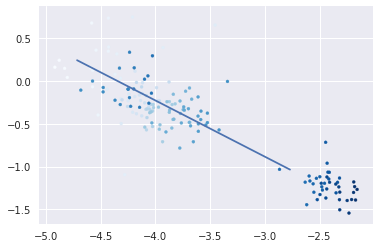

[[ 0.00154496]
 [-0.00084404]]
[-5.52501184  0.70098702]


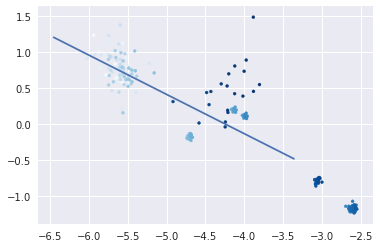

[[ 0.00093185]
 [-0.00067541]]
[ 0.9506294   0.97833281]


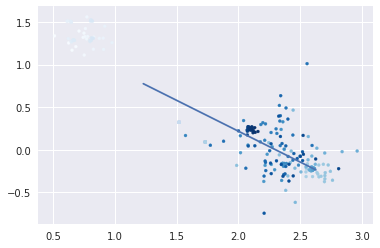

[[ 0.00158592]
 [-0.00149778]]
[-0.50336962  2.60050406]


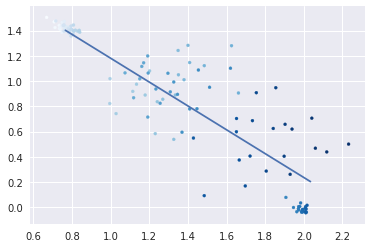

[[ 0.03270035]
 [ 0.02096579]]
[-63.40850349 -37.79246775]


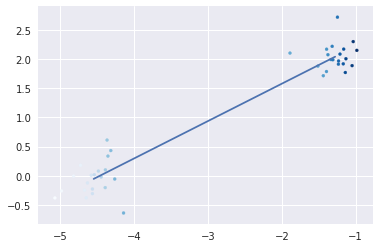

[[ 0.00272931]
 [-0.00073854]]
[-4.71227792 -0.74587901]


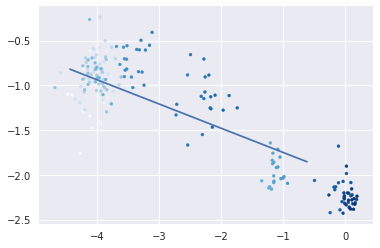

[[ 0.00045393]
 [-0.00011991]]
[-2.98356577 -0.51666565]
[[ 0.00022019]
 [ 0.00016309]]
[ 1.77016989  0.06648002]


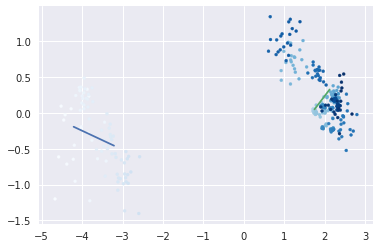

[[ 0.00403348]
 [ 0.00376968]]
[-9.5889576  -7.10595442]


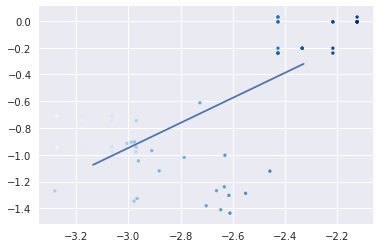

[[ 0.03089989]
 [ 0.01410115]]
[-59.5223836  -25.76131563]


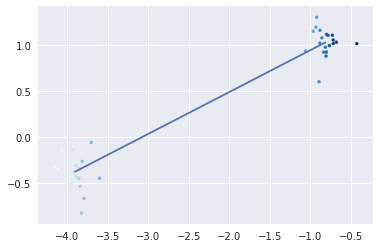

[[ 0.01079266]
 [ 0.00183658]]
[-19.19876251  -3.83681552]


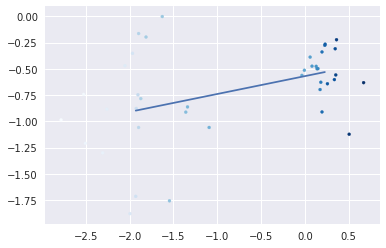

[[ 0.00667855]
 [ 0.00429595]]
[-9.2597954  -4.21727899]


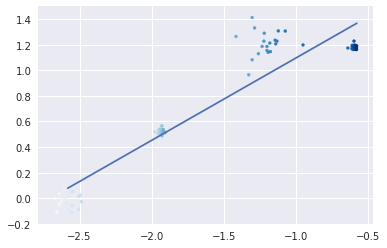

[[  4.19322810e-04]
 [ -7.09555555e-05]]
[-1.69387631 -0.41985374]
[[  6.31220201e-05]
 [  3.32806342e-06]]
[ 1.79341373  0.32859358]


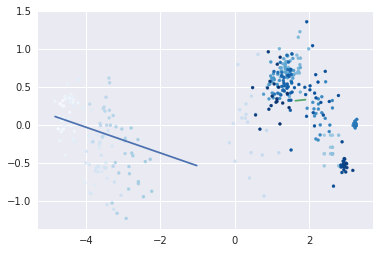

[[ 0.00434951]
 [-0.00091657]]
[-2.44634592  0.73137193]
[[ 0.00094331]
 [-0.00038385]]
[ 1.07820265  0.81057587]


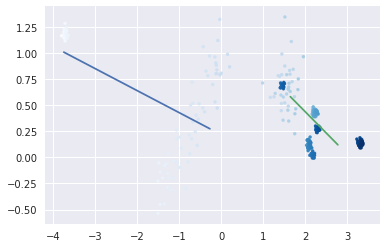

[[ 0.01078098]
 [-0.00176101]]
[-22.94511035   3.31391017]


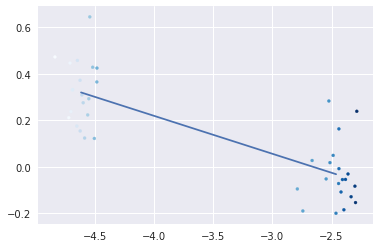

[[ 0.00073169]
 [ 0.00018201]]
[ 0.64402041  1.24287989]
[[ 0.00087723]
 [-0.00023186]]
[ 1.95945821  0.03151714]


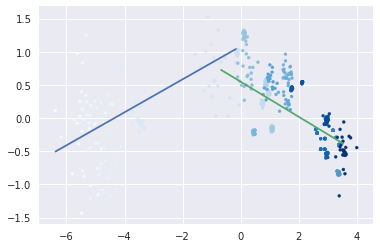

[[ -2.54577331e-05]
 [  2.25894855e-04]]
[-4.50167121  0.57245826]
[[  4.39073257e-04]
 [  1.80022769e-05]]
[ 1.40105612  0.33676272]


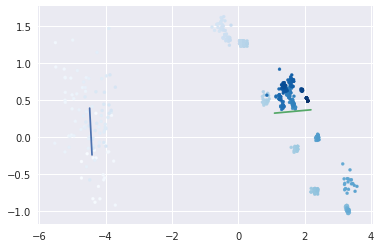

[[ 0.00682523]
 [ 0.00232978]]
[-14.11783913  -3.13261263]


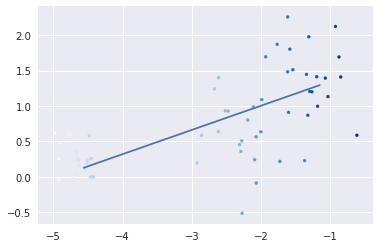

[[ 0.00231684]
 [ 0.00154942]]
[-8.04174464 -2.28588846]


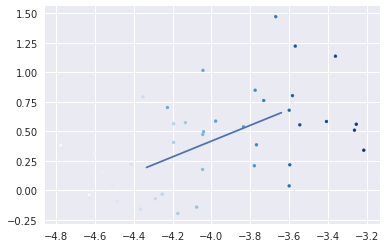

[[  1.04886263e-03]
 [  4.96174860e-05]]
[ 1.72735989 -0.14414945]
[[ 0.00089042]
 [-0.00010314]]
[ 2.36613968 -0.48288316]


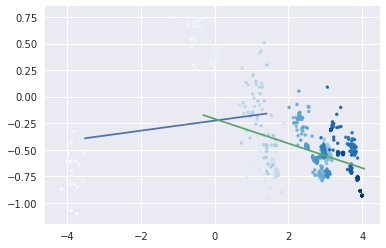

[[ 0.0038304 ]
 [-0.00016687]]
[-4.52244808  0.05337236]
[[ 0.00121579]
 [-0.00020977]]
[-0.23538898  0.47535811]


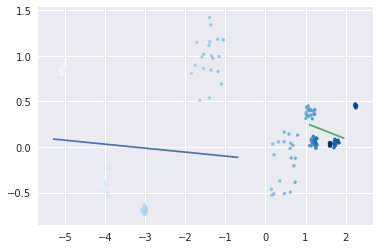

[[ 0.00189109]
 [ 0.00092505]]
[-4.67639978 -0.44881949]


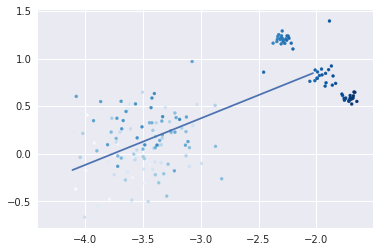

[[ 0.00065843]
 [ 0.00044743]]
[-1.63520068 -1.51343043]
[[-0.00023237]
 [ 0.00096511]]
[ 1.73950079 -1.19266472]


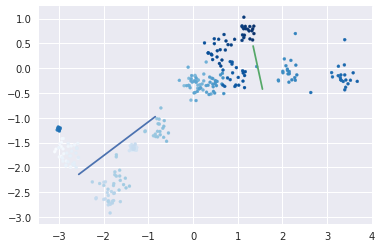

[[ 0.02714089]
 [ 0.01793481]]
[-52.5735629  -32.45801193]


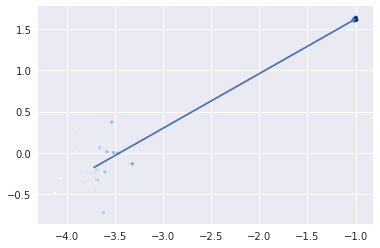

[[ 0.00088557]
 [ 0.00012474]]
[-1.83734067  0.2803096 ]
[[ 0.00180028]
 [-0.00092666]]
[ 0.10541128  1.06349531]


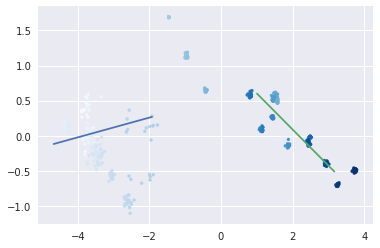

[[  2.35344037e-04]
 [ -5.52229052e-05]]
[-3.23768407 -0.81799792]
[[ 0.00046145]
 [-0.00016867]]
[ 1.40056113  0.35275801]


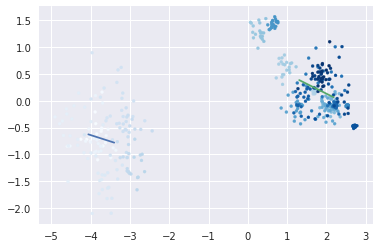

[[ 0.01128421]
 [ 0.02157498]]
[-21.57244625 -39.24265722]


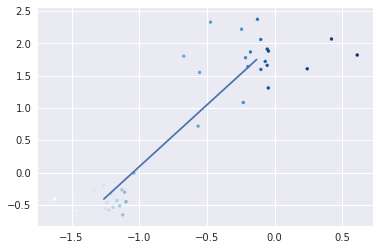

[[  6.84229836e-04]
 [  3.37483249e-05]]
[ 0.10854594  0.0806703 ]
[[ 0.00064393]
 [-0.00039501]]
[ 1.9903024  -0.05404086]


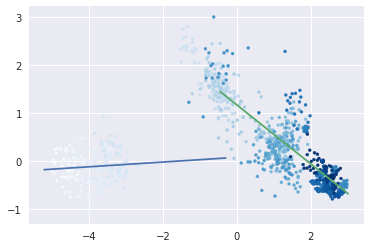

[[ 0.00312363]
 [-0.00054925]]
[ 8.74356947 -1.7936104 ]
[[  4.95571718e-04]
 [  3.47552449e-05]]
[ 2.17494841 -0.17210287]


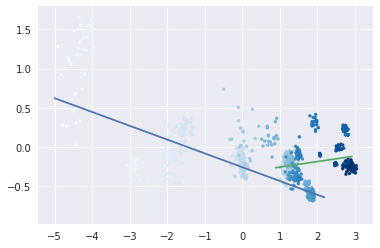

[[ 0.00116482]
 [-0.00014695]]
[-3.05809084 -0.66475127]


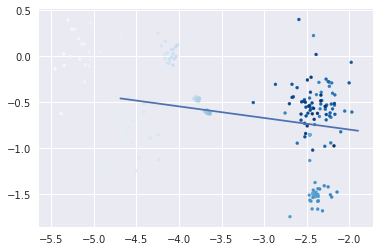

[[-0.00328466]
 [-0.000391  ]]
[ 5.3655695   1.56982393]


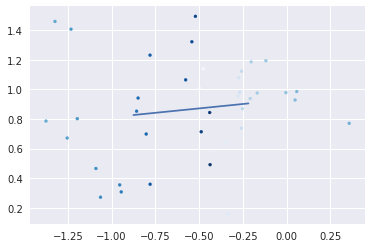

In [49]:
# flow vectors for each NGAs
nga_dict = {key:list() for key in ngas}
vec_coef1 = list() # coefficients for overall flow vectors for each ngas in the first gaussian
vec_ic1 = list() # intercept for overall flow vectors for each ngas in the first gaussian
vec_coef2 = list() # coefficients for overall flow vectors for each ngas in the second gaussian
vec_ic2 = list() # intercept for overall flow vectors for each ngas in the second gaussian

for idx in range(len(data)):
    nga = pnas_data1.loc[idx].NGA
    nga_dict[nga].append((data[:,0][idx], data[:,1][idx], times[idx][0], idx))            

for i in range(len(ngas)):    

    nga_pc1 = [p for p,_,_,_ in nga_dict[ngas[i]]]
    nga_pc2 = [j for _,j,_,_ in nga_dict[ngas[i]]]
    nga_time = [k for _,_,k,_ in nga_dict[ngas[i]]]

    nga_pc1 = [x for _,x,_ in sorted(zip(nga_time, nga_pc1, nga_pc2))]
    nga_pc2 = [y for _,_,y in sorted(zip(nga_time, nga_pc1, nga_pc2))]

    nga_pc_gauss1 = [[p,j] for p,j,_,t in nga_dict[ngas[i]] if t in gauss1_idx]
    nga_pc_gauss2 = [[p,j] for p,j,_,t in nga_dict[ngas[i]] if t in gauss2_idx]

    nga_time1 = np.asarray([k for _,_,k,t in nga_dict[ngas[i]] if t in gauss1_idx])
    nga_time2 = np.asarray([k for _,_,k,t in nga_dict[ngas[i]] if t in gauss2_idx])
    
    assert len(nga_pc_gauss1) == len(nga_time1)
    assert len(nga_pc_gauss2) == len(nga_time2)
     
    #fit linear regression vector
    if len(nga_time1) == 0:
        ols2 = linear_model.LinearRegression()
        model2 = ols2.fit(nga_time2.reshape(-1,1), nga_pc_gauss2)
        
        print(model2.coef_)
        print(model2.intercept_)
        
        vec_coef2.append(model2.coef_)
        vec_ic2.append(model2.intercept_)
        
        yfit2 = model2.predict(np.sort(nga_time2).reshape(-1, 1))
        plt.plot([p for p, _ in yfit2], [q for _, q in yfit2])
        
        vec_coef2.append(model2.coef_)
        vec_ic2.append(model2.intercept_)
        
    elif len(nga_time2) == 0:
        ols1 = linear_model.LinearRegression()
        model1 = ols1.fit(nga_time1.reshape(-1,1), nga_pc_gauss1)
        
        print(model1.coef_)
        print(model1.intercept_)
        
        vec_coef1.append(model1.coef_)
        vec_ic1.append(model1.intercept_)
        
        xfit1 = np.linspace(-6, 4, len(nga_time1))
        yfit1 = model1.predict(np.sort(nga_time1).reshape(-1, 1))

        plt.plot([p for p, _ in yfit1], [q for _, q in yfit1])
        
        vec_coef1.append(model1.coef_)
        vec_ic1.append(model1.intercept_)


    else:
        ols1 = linear_model.LinearRegression()
        model1 = ols1.fit(nga_time1.reshape(-1,1), nga_pc_gauss1)
        ols2 = linear_model.LinearRegression()
        model2 = ols2.fit(nga_time2.reshape(-1,1), nga_pc_gauss2)
        
        print(model1.coef_)
        print(model1.intercept_)
        print(model2.coef_)
        print(model2.intercept_)

        vec_coef1.append(model1.coef_)
        vec_ic1.append(model1.intercept_)
        vec_coef2.append(model2.coef_)
        vec_ic2.append(model2.intercept_)

        xfit1 = np.linspace(-6, 4, len(nga_time1))
        xfit2 = np.linspace(-6, 4, len(nga_time2))
        yfit1 = model1.predict(np.sort(nga_time1).reshape(-1, 1))
        yfit2 = model2.predict(np.sort(nga_time2).reshape(-1, 1))
        
        plt.plot([p for p, _ in yfit1], [q for _, q in yfit1])
        plt.plot([p for p, _ in yfit2], [q for _, q in yfit2])

        vec_coef1.append(model1.coef_)
        vec_ic1.append(model1.intercept_)
        vec_coef2.append(model2.coef_)
        vec_ic2.append(model2.intercept_)

    plt.scatter(nga_pc1, nga_pc2, s=9, c=range(len(nga_pc1)), cmap = 'Blues')
    plt.show()
    plt.close()
    
gauss1_coef = np.mean(vec_coef1, axis=0)
gauss1_ic = np.mean(vec_ic1, axis=0)
gauss2_coef = np.mean(vec_coef2, axis=0)
gauss2_ic = np.mean(vec_ic2, axis=0)

arctan 0.00594013346349
direction [ 2.00416743]
[-11.12917721  -5.44696762]
[[ 0.00073827]
 [-0.00024342]]
direction [-3.03291715]
[ 1.28507394  0.36733471]


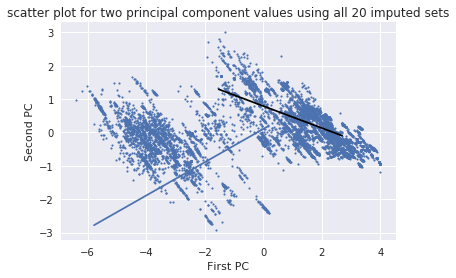

In [87]:
print("arctan",np.arctan(gauss1_coef[0][0]))

print("direction", gauss1_coef[0]/gauss1_coef[1])
print(gauss1_ic)
print(gauss2_coef)
print("direction", gauss2_coef[0]/gauss2_coef[1])
print(gauss2_ic)
X, Y = data[:, 0], data[:, 1]

plt.scatter(X, Y, s=3)
plt.title('scatter plot for two principal component values using all 20 imputed sets')
plt.xlabel('First PC')
plt.ylabel('Second PC')

gauss1_t = sorted(gauss1_time)
gauss2_t = sorted(gauss2_time)
ic1 = np.asarray([gauss1_ic]).T
ic2 = np.asarray([gauss2_ic]).T

def line_vec(time, coef, intercept):
    return [(coef*i+intercept) for i in time]

gauss1 = line_vec(gauss1_t, gauss1_coef, ic1)
gauss2 = line_vec(gauss2_t, gauss2_coef, ic2)
gauss1_x= [i for i,j in gauss1 if (i<=4 and i>=-6) and (j>=-3 and j<=3)]
gauss1_y= [j for i,j in gauss1 if (i<=4 and i>=-6) and (j>=-3 and j<=3)]
gauss2_x= [i for i,j in gauss2 if (i<=4 and i>=-6) and (j>=-3 and j<=3)]
gauss2_y= [j for i,j in gauss2 if (i<=4 and i>=-6) and (j>=-3 and j<=3)]
plt.plot(gauss1_x, gauss1_y)
plt.plot(gauss2_x, gauss2_y, color='Black')
plt.show()
plt.close()


In [29]:
single_impute = list()

for i in range(414):
    j = np.random.randint(0, 20)
    single_impute.append(data[i+414*j])
    
assert len(single_impute) == 414 #check if the matrix contains all of the 414 rows 

single_impute = np.asarray(single_impute)

nga_dict = {key:list() for key in ngas}
vec_coef1 = list() # coefficients for overall flow vectors for each ngas in the first gaussian
vec_ic1 = list() # intercept for overall flow vectors for each ngas in the first gaussian
vec_coef2 = list() # coefficients for overall flow vectors for each ngas in the second gaussian
vec_ic2 = list() # intercept for overall flow vectors for each ngas in the second gaussian

for idx in range(len(single_impute)):
    nga = pnas_data1.loc[idx].NGA
    nga_dict[nga].append((single_impute[:,0][idx], single_impute[:,1][idx], times[idx][0], idx))            

for i in range(30):    

    nga_pc1 = [i for i,_,_,_ in nga_dict[ngas[i]]]
    nga_pc2 = [j for _,j,_,_ in nga_dict[ngas[i]]]
    nga_time = [k for _,_,k,_ in nga_dict[ngas[i]]]

    nga_pc1 = [x for _,x,_ in sorted(zip(nga_time, nga_pc1, nga_pc2))]
    nga_pc2 = [y for _,_,y in sorted(zip(nga_time, nga_pc1, nga_pc2))]

    nga_pc_gauss1 = [np.asarray([i,j]) for i, j in zip([i for i,_,_,t in nga_dict[ngas[i]] if t in gauss1_idx], 
                    [j for _,j,_,t in nga_dict[ngas[i]] if t in gauss1_idx])]
    nga_pc_gauss2 = [np.asarray([i,j]) for i, j in zip([i for i,_,_,t in nga_dict[ngas[i]] if t in gauss2_idx], 
                    [j for _,j,_,t in nga_dict[ngas[i]] if t in gauss2_idx])]
    nga_time1 = np.asarray([k for _,_,k,t in nga_dict[ngas[i]] if t in gauss1_idx])
    nga_time2 = np.asarray([k for _,_,k,t in nga_dict[ngas[i]] if t in gauss2_idx])
    
    assert len(nga_pc_gauss1) == len(nga_time1)
    assert len(nga_pc_gauss2) == len(nga_time2)
    
    #fit linear regression vector
    if len(nga_time1) == 0:
        ols2 = linear_model.LinearRegression()
        model2 = ols2.fit(nga_time2.reshape(-1,1), nga_pc_gauss2)
        vec_coef2.append(model2.coef_)
        vec_ic2.append(model2.intercept_)
        

    elif len(nga_time2) == 0:
        ols1 = linear_model.LinearRegression()
        model1 = ols1.fit(nga_time1.reshape(-1,1), nga_pc_gauss1)
        vec_coef1.append(model1.coef_)
        vec_ic1.append(model1.intercept_)

    else:
        ols1 = linear_model.LinearRegression()
        model1 = ols1.fit(nga_time1.reshape(-1,1), nga_pc_gauss1)
        ols2 = linear_model.LinearRegression()
        model2 = ols2.fit(nga_time2.reshape(-1,1), nga_pc_gauss2)

        vec_coef1.append(model1.coef_)
        vec_ic1.append(model1.intercept_)
        vec_coef2.append(model2.coef_)
        vec_ic2.append(model2.intercept_)

    print(model1.coef_)
    print(model1.intercept_)
    print(model2.coef_)
    print(model2.intercept_)
    
    plt.scatter(nga_pc1, nga_pc2, s=9, c=range(len(nga_pc1)), cmap = 'Blues')
    
    xfit1 = xfit2 = np.linspace(-6, 4, 1000)
    yfit1 = model1.predict(xfit1.reshape(-1, 1)); yfit2 = model2.predict(xfit2.reshape(-1,1))
    
    plt.plot(xfit1, yfit1)
    plt.plot(xfit2, yfit2)
    plt.show()
    plt.close()
    

gauss1_coef = np.mean(vec_coef1, axis=1)
gauss1_ic = np.mean(vec_ic1, axis=1)
gauss2_coef = np.mean(vec_coef2, axis=0)
gauss2_ic = np.mean(vec_ic2, axis=0)


[1 2]
